In [1]:

import pandas as pd
import numpy as np
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss,MAE, RMSE, MAPE, SMAPE
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pytorch_forecasting.models import TimeXer
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from lightning.pytorch.callbacks import Callback

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
df = pd.read_csv("data/timexer.csv", parse_dates=["date"])
df = df.sort_values("date")
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds().astype(int)
df["series_id"] = 0

In [4]:
num_train = int(len(df) * 0.7)
num_test  = int(len(df) * 0.2)
num_vali  = len(df) - num_train - num_test

In [5]:
train_df = df.iloc[:num_train]
val_df   = df.iloc[num_train : num_train + num_vali]
test_df  = df.iloc[num_train + num_vali :]


In [6]:
max_encoder_length = 50
max_prediction_length = 5
static_categoricals = []
static_reals = []
time_varying_known_reals = [
    "bytes_op0","bytes_op1","bytes_sum","io_count",
    "read_ops_count","write_ops_count",
    "bytes_sum_ema_short","bytes_sum_ema_long",
    "bytes_sum_macd","bytes_sum_macd_signal",
]
time_varying_unknown_reals = ["duration_sum"]
group_ids = ["series_id"]
target = "duration_sum"
batch_size = 64
epochs = 50



In [7]:
covariate_scalers = {
    var: GroupNormalizer(groups=["series_id"]) 
    for var in time_varying_known_reals
}

In [8]:
model_kwargs = dict(
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    loss=QuantileLoss(quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98, 0.99,0.992,0.994,0.996,0.998,0.999]),  
    output_size=23,              # default: QuantileLoss
    logging_metrics=[SMAPE(),MAE(), RMSE(), MAPE()],
    log_interval=10,
    reduce_on_plateau_patience=4,
)


In [9]:
trainer_kwargs = dict(
    max_epochs=epochs,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
)

In [10]:
training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length,
        static_categoricals=static_categoricals, static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
       scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    )
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=False)

    # Dataloaders
train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=0)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=False)
test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [11]:
horizon =5

In [12]:
ckpt_dir = f"ckpts_anomaly_nostatic/horizon_{horizon}"
os.makedirs(ckpt_dir, exist_ok=True)

In [13]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        verbose=True,

    )
class PrintLossCallback(Callback):
    def __init__(self, horizon: int):
        super().__init__()
        self.horizon = horizon

    def on_train_epoch_end(self, trainer, pl_module):
        # logged_metrics is updated after validation, so both train_loss and val_loss should be present
        epoch = trainer.current_epoch
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss")
        val_loss   = metrics.get("val_loss")
        print(
            f"Horizon={self.horizon}  "
            f"Epoch={epoch:02d}  "
            f"train_loss={train_loss:.4f}  "
            f"val_loss={val_loss:.4f}"
        )


In [ ]:
print_cb    = PrintLossCallback(horizon)

    # Model & Trainer
tft = TemporalFusionTransformer.from_dataset(training, **model_kwargs )
trainer = Trainer(callbacks=[early_stop, checkpoint,print_cb], **trainer_kwargs)

    # Fit
trainer.fit(tft, train_loader, val_loader)

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=00  train_loss=0.0003  val_loss=0.0004


Epoch 0, global step 2176: 'val_loss' reached 0.00042 (best 0.00042), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=00-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=01  train_loss=0.0002  val_loss=0.0004


Epoch 1, global step 4352: 'val_loss' reached 0.00041 (best 0.00041), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=01-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=02  train_loss=0.0002  val_loss=0.0004


Epoch 2, global step 6528: 'val_loss' reached 0.00041 (best 0.00041), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=02-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=03  train_loss=0.0002  val_loss=0.0004


Epoch 3, global step 8704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=04  train_loss=0.0002  val_loss=0.0004


Epoch 4, global step 10880: 'val_loss' reached 0.00039 (best 0.00039), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=04-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=05  train_loss=0.0002  val_loss=0.0004


Epoch 5, global step 13056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=06  train_loss=0.0002  val_loss=0.0004


Epoch 6, global step 15232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=07  train_loss=0.0002  val_loss=0.0004


Epoch 7, global step 17408: 'val_loss' reached 0.00039 (best 0.00039), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=07-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=08  train_loss=0.0002  val_loss=0.0004


Epoch 8, global step 19584: 'val_loss' reached 0.00038 (best 0.00038), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=08-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=09  train_loss=0.0002  val_loss=0.0006


Epoch 9, global step 21760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=10  train_loss=0.0002  val_loss=0.0004


Epoch 10, global step 23936: 'val_loss' reached 0.00038 (best 0.00038), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=10-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=11  train_loss=0.0002  val_loss=0.0004


Epoch 11, global step 26112: 'val_loss' reached 0.00036 (best 0.00036), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=11-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=12  train_loss=0.0002  val_loss=0.0004


Epoch 12, global step 28288: 'val_loss' reached 0.00036 (best 0.00036), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_anomaly_nostatic/horizon_5/best-epoch=12-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=13  train_loss=0.0002  val_loss=0.0004


Epoch 13, global step 30464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=14  train_loss=0.0002  val_loss=0.0004


Epoch 14, global step 32640: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=15  train_loss=0.0002  val_loss=0.0004


Epoch 15, global step 34816: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=16  train_loss=0.0002  val_loss=0.0004


Epoch 16, global step 36992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=17  train_loss=0.0002  val_loss=0.0005


Epoch 17, global step 39168: 'val_loss' was not in top 1


: 

In [14]:
model_an = TemporalFusionTransformer.load_from_checkpoint("ckpts_anomaly_nostatic/horizon_5/best-epoch=12-val_loss=0.0004.ckpt")
raw_outputs = model_an.predict(
    test_loader,
    mode="raw",           # full model outputs, including the `prediction` tensor
    return_x=False,       # we only want the model outputs
    return_y=False,
    batch_size=batch_size,
    num_workers=0
)

# 2. Extract the prediction tensor: shape = (n_windows, prediction_length, n_quantiles)
#    In PyTorch Forecasting v0.10+, raw_outputs is an AttributeDict, so:
pred_tensor = raw_outputs["prediction"]  
# it’s a torch.Tensor; move to CPU/NumPy:
preds = pred_tensor.detach().cpu().numpy()  
# Now `preds.shape == (n_windows, horizon, n_quantiles)`

# 3. Gather the true values in the same sliding-window order:
#    This is the concatenation of the decoder’s true targets that your dataset would produce.
actuals = np.concatenate([
    y.detach().cpu().numpy()
    for _, (y, _) in iter(test_loader)
], axis=0)
# actuals.shape == (n_windows, horizon)

# 4. Compute MSE for each quantile over **all** time-steps & windows:
quantile_levels =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98, 0.99,0.992,0.994,0.996,0.998,0.999]  # e.g. [0.1, 0.5, 0.9]
for q_idx, q in enumerate(quantile_levels):
    # flatten windows × time-steps into one long vector
    q_preds = preds[:, :, q_idx].reshape(-1)
    y_true = actuals.reshape(-1)
    mse_q = mean_squared_error(y_true, q_preds)
    print(f"Quantile {q:>4.2f} — MSE = {mse_q:.6f}")

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('N

Quantile 0.10 — MSE = 0.000034
Quantile 0.20 — MSE = 0.000030
Quantile 0.30 — MSE = 0.000028
Quantile 0.40 — MSE = 0.000027
Quantile 0.50 — MSE = 0.000026
Quantile 0.60 — MSE = 0.000025
Quantile 0.70 — MSE = 0.000024
Quantile 0.80 — MSE = 0.000024
Quantile 0.90 — MSE = 0.000024
Quantile 0.91 — MSE = 0.000024
Quantile 0.92 — MSE = 0.000024
Quantile 0.93 — MSE = 0.000024
Quantile 0.94 — MSE = 0.000024
Quantile 0.95 — MSE = 0.000024
Quantile 0.96 — MSE = 0.000024
Quantile 0.97 — MSE = 0.000024
Quantile 0.98 — MSE = 0.000026
Quantile 0.99 — MSE = 0.000031
Quantile 0.99 — MSE = 0.000033
Quantile 0.99 — MSE = 0.000039
Quantile 1.00 — MSE = 0.000051
Quantile 1.00 — MSE = 0.000083
Quantile 1.00 — MSE = 0.000140


In [15]:
# Step 1: Extract all ground truth duration_sum from training
train_targets = train_df["duration_sum"].values

# Step 2: Define spike threshold from training set (e.g., 99th percentile)
spike_threshold = np.percentile(train_targets, 99.99)

print(f"Spike threshold (from training set): {spike_threshold:.6f}")


Spike threshold (from training set): 0.074301


In [16]:
test_actuals = test_df["duration_sum"].values

In [17]:
anomaly_labels = (test_actuals > spike_threshold).astype(int)

# Step 4: Add labels to the test DataFrame
test_df_1 = test_df.copy()  # avoid overwriting original
test_df_1["is_anomaly"] = anomaly_labels

# Step 5: Optionally, print a summary
print(test_df_1["is_anomaly"].value_counts())

is_anomaly
0    39774
1       41
Name: count, dtype: int64


In [18]:
quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98, 0.99,0.992,0.994,0.996,0.998,0.999]
batch_size = 64 


In [19]:
model = TemporalFusionTransformer.load_from_checkpoint("ckpts_anomaly_nostatic/horizon_5/best-epoch=12-val_loss=0.0004.ckpt")

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [20]:
raw = model.predict(
    test_loader,
    mode="raw",
    return_x=False, return_y=False,
    batch_size=batch_size, num_workers=0
)

pred_tensor = raw["prediction"]
preds = pred_tensor.detach().cpu().numpy()   # (n_windows, 5, n_quantiles)




💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


In [21]:
labels_all = test_df_1["is_anomaly"].values

# For step_ahead = k, predictions correspond to test_df indices starting at:
# max_encoder_length + (k-1)
aligned_labels_by_step = {
    k: labels_all[max_encoder_length + (k - 1):]
    for k in range(1, horizon + 1)
}


In [22]:
# Step 6: Choose quantile for evaluation (e.g., q=0.99)
quantile_to_check = 0.90
q_index = quantile_levels.index(quantile_to_check)

In [23]:
print("preds.shape =", preds.shape)  # should be (n_windows, 5, n_quantiles)


preds.shape = (39761, 5, 23)


In [24]:
# Step 7: Extract predicted values at chosen quantile
step_ahead = 5
q_preds = preds[:, step_ahead - 1, q_index]

# Step 8: Align prediction to target (prediction for t+1 made at t)
predicted_anomalies = (q_preds > spike_threshold).astype(int) # prediction from t, for t+1


In [ ]:
# precision = precision_score(aligned_labels, predicted_anomalies, zero_division=0)
# recall    = recall_score(aligned_labels, predicted_anomalies, zero_division=0)
# f1        = f1_score(aligned_labels, predicted_anomalies, zero_division=0)
# accuracy  = accuracy_score(aligned_labels, predicted_anomalies)

# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9992
Precision: 0.6279
Recall:    0.6585
F1 Score:  0.6429


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98, 0.99,0.992,0.994,0.996,0.998,0.999]

# choose which quantiles to evaluate for anomaly detection (usually high quantiles)
eval_quantiles = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

results = []  # store results rows

for step_ahead in range(1, horizon + 1):  # 1..5
    # predicted quantiles for that horizon step: preds[:, step_ahead-1, :]
    for q in eval_quantiles:
        q_index = quantile_levels.index(q)

        # predictions for t+step_ahead at quantile q
        q_preds = preds[:, step_ahead - 1, q_index]  # shape (n_windows,)

        # anomaly prediction based on threshold
        predicted_anomalies = (q_preds > spike_threshold).astype(int)

        # align true labels for this step
        y_true_labels = aligned_labels_by_step[step_ahead]

        # IMPORTANT: match lengths (due to windowing, should usually match, but trim safely)
        n = min(len(y_true_labels), len(predicted_anomalies))
        y_true_labels = y_true_labels[:n]
        predicted_anomalies = predicted_anomalies[:n]

        precision = precision_score(y_true_labels, predicted_anomalies, zero_division=0)
        recall    = recall_score(y_true_labels, predicted_anomalies, zero_division=0)
        f1        = f1_score(y_true_labels, predicted_anomalies, zero_division=0)
        accuracy  = accuracy_score(y_true_labels, predicted_anomalies)

        results.append({
            "step_ahead": step_ahead,
            "quantile": q,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": accuracy,
        })

        print(
            f"[t+{step_ahead}] q={q:.2f} | "
            f"Prec={precision:.4f} Rec={recall:.4f} F1={f1:.4f} Acc={accuracy:.4f}"
        )


[t+1] q=0.90 | Prec=0.5672 Rec=0.9268 F1=0.7037 Acc=0.9992
[t+1] q=0.91 | Prec=0.5588 Rec=0.9268 F1=0.6972 Acc=0.9992
[t+1] q=0.92 | Prec=0.5588 Rec=0.9268 F1=0.6972 Acc=0.9992
[t+1] q=0.93 | Prec=0.5507 Rec=0.9268 F1=0.6909 Acc=0.9991
[t+1] q=0.94 | Prec=0.5507 Rec=0.9268 F1=0.6909 Acc=0.9991
[t+1] q=0.95 | Prec=0.5352 Rec=0.9268 F1=0.6786 Acc=0.9991
[t+1] q=0.96 | Prec=0.5205 Rec=0.9268 F1=0.6667 Acc=0.9990
[t+1] q=0.97 | Prec=0.4872 Rec=0.9268 F1=0.6387 Acc=0.9989
[t+1] q=0.98 | Prec=0.4578 Rec=0.9268 F1=0.6129 Acc=0.9988
[t+1] q=0.99 | Prec=0.3689 Rec=0.9268 F1=0.5278 Acc=0.9983
[t+2] q=0.90 | Prec=0.5254 Rec=0.7561 F1=0.6200 Acc=0.9990
[t+2] q=0.91 | Prec=0.5254 Rec=0.7561 F1=0.6200 Acc=0.9990
[t+2] q=0.92 | Prec=0.5254 Rec=0.7561 F1=0.6200 Acc=0.9990
[t+2] q=0.93 | Prec=0.5254 Rec=0.7561 F1=0.6200 Acc=0.9990
[t+2] q=0.94 | Prec=0.5082 Rec=0.7561 F1=0.6078 Acc=0.9990
[t+2] q=0.95 | Prec=0.5000 Rec=0.7561 F1=0.6019 Acc=0.9990
[t+2] q=0.96 | Prec=0.4769 Rec=0.7561 F1=0.5849 Acc=0.99

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98, 0.99,0.992,0.994,0.996,0.998,0.999]
eval_quantiles   = [0.6,0.7,0.8,0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

results = []

for q in eval_quantiles:
    q_index = quantile_levels.index(q)

    all_true = []
    all_pred = []

    for step_ahead in range(1, horizon + 1):  # 1..H
        # predicted quantiles for this step
        q_preds_step = preds[:, step_ahead - 1, q_index]
        pred_labels_step = (q_preds_step > spike_threshold).astype(int)

        # true labels aligned for this step
        true_labels_step = aligned_labels_by_step[step_ahead]

        # trim to match lengths safely
        n = min(len(true_labels_step), len(pred_labels_step))
        true_labels_step = true_labels_step[:n]
        pred_labels_step = pred_labels_step[:n]

        all_true.append(true_labels_step)
        all_pred.append(pred_labels_step)

    # concatenate across steps -> one long vector per quantile
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)

    precision = precision_score(all_true, all_pred, zero_division=0)
    recall    = recall_score(all_true, all_pred, zero_division=0)
    f1        = f1_score(all_true, all_pred, zero_division=0)
    accuracy  = accuracy_score(all_true, all_pred)

    results.append({
        "quantile": q,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    })

    print(
        f"[ALL steps t+1..t+{horizon}] q={q:.2f} | "
        f"Prec={precision:.4f} Rec={recall:.4f} F1={f1:.4f} Acc={accuracy:.4f}"
    )


[ALL steps t+1..t+5] q=0.60 | Prec=0.0000 Rec=0.0000 F1=0.0000 Acc=0.9990
[ALL steps t+1..t+5] q=0.70 | Prec=0.0000 Rec=0.0000 F1=0.0000 Acc=0.9989
[ALL steps t+1..t+5] q=0.80 | Prec=0.5787 Rec=0.6098 F1=0.5938 Acc=0.9991
[ALL steps t+1..t+5] q=0.90 | Prec=0.5560 Rec=0.6537 F1=0.6009 Acc=0.9991
[ALL steps t+1..t+5] q=0.91 | Prec=0.5403 Rec=0.6537 F1=0.5916 Acc=0.9991
[ALL steps t+1..t+5] q=0.92 | Prec=0.5425 Rec=0.6537 F1=0.5929 Acc=0.9991
[ALL steps t+1..t+5] q=0.93 | Prec=0.5339 Rec=0.6537 F1=0.5877 Acc=0.9991
[ALL steps t+1..t+5] q=0.94 | Prec=0.5154 Rec=0.6537 F1=0.5763 Acc=0.9990
[ALL steps t+1..t+5] q=0.95 | Prec=0.5019 Rec=0.6537 F1=0.5678 Acc=0.9990
[ALL steps t+1..t+5] q=0.96 | Prec=0.4685 Rec=0.6537 F1=0.5458 Acc=0.9989
[ALL steps t+1..t+5] q=0.97 | Prec=0.4281 Rec=0.6537 F1=0.5174 Acc=0.9987
[ALL steps t+1..t+5] q=0.98 | Prec=0.3890 Rec=0.6585 F1=0.4891 Acc=0.9986
[ALL steps t+1..t+5] q=0.99 | Prec=0.3072 Rec=0.6878 F1=0.4247 Acc=0.9981


In [28]:
import pandas as pd

metrics_df = pd.DataFrame(results)

quantiles  = metrics_df["quantile"].values
precision  = metrics_df["precision"].values
recall     = metrics_df["recall"].values


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


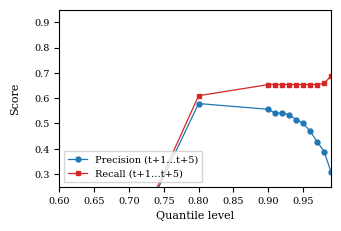

: 

In [ ]:
import matplotlib.pyplot as plt

# ---- SAME publication-style settings ----
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "axes.linewidth": 0.8,
    "ps.fonttype": 42,
    "pdf.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(4, 2.3))

# Plot precision (collective over all steps)
ax.plot(
    quantiles,
    precision,
    marker="o",
    markersize=3.5,
    linewidth=0.9,
    label="Precision (t+1…t+5)",
    color="#1f77b4"
)

# Plot recall (collective over all steps)
ax.plot(
    quantiles,
    recall,
    marker="s",
    markersize=3.5,
    linewidth=0.9,
    label="Recall (t+1…t+5)",
    color="#d62728"
)

# Axis labels
ax.set_xlabel("Quantile level")
ax.set_ylabel("Score", labelpad=10)

# y-axis range and ticks (adjust if needed)
ax.set_ylim(0.25, 0.95)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# x-axis limits
ax.set_xlim(quantiles.min(), quantiles.max())

# Grid (optional, ACM-friendly)
ax.set_axisbelow(True)

# Legend
ax.legend(
    loc="lower left",
    fontsize=7,
    frameon=True,
    fancybox=False
)

# Prevent label clipping
fig.subplots_adjust(left=0.22)

# Save EPS for paper
fig.savefig(
    "plots/precision_recall_collective_h5.eps",
    format="eps",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.08
)

plt.show()


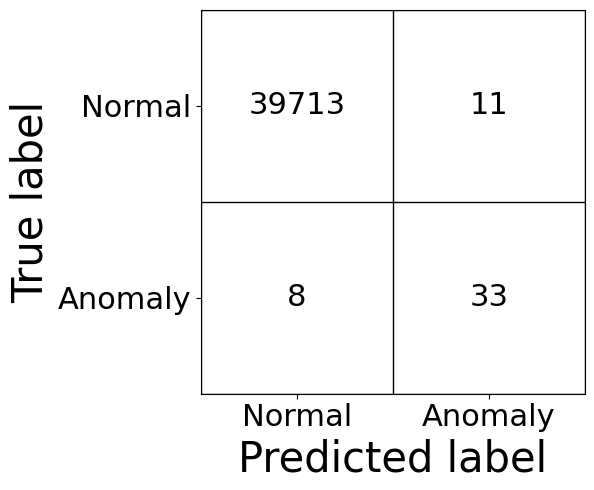

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set the quantile to check
quantile_to_check = 0.90
q_index = quantile_levels.index(quantile_to_check)

# Extract predicted values at q = 0.92
q_preds = preds[:, 0, q_index]

# Align the ground truth anomaly labels
aligned_labels = test_df_1["is_anomaly"].values[max_encoder_length:]

# Predict anomaly based on threshold
predicted_anomalies = (q_preds > spike_threshold).astype(int)

cm = confusion_matrix(aligned_labels, predicted_anomalies)
labels = ["Normal", "Anomaly"]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot blank cells with grid
ax.imshow(np.ones_like(cm), cmap="gray", vmin=0, vmax=1)  # just white background
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=22)
ax.set_yticklabels(labels, fontsize=22)

# Axis labels
ax.set_xlabel("Predicted label", fontsize=30)
ax.set_ylabel("True label", fontsize=30)
# ax.set_title(f"Confusion Matrix at Quantile q = 0.93", fontsize=18)

# Grid lines
for edge in ['left', 'right', 'top', 'bottom']:
    ax.spines[edge].set_visible(True)
ax.set_xticks(np.arange(len(labels) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(labels) + 1) - 0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# Text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center", fontsize=22, color="black")

plt.tight_layout()
fig.savefig("plots/cf.eps", format="eps",dpi=300,bbox_inches="tight")
plt.show()